In [0]:
import numpy as np
import networkx as nx
import pandas as pd
import random
import functools
from similarities import *
from itertools import combinations 
import math

In [0]:
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

In [0]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [0]:
def load_restaurant_dataset():
    path = 'dataset_ubicomp2013_checkins.txt'
#     lines = (line.decode('utf-8') for line in path)
    infile = open(path, 'r')
    a = set()
    b = set()
    edges = []
    for line in infile:
        s=line.strip().split(None)
        u=-1*int(s.pop(0)) -10
        v=int(s.pop(0))
        a.add(u)
        b.add(v)
        edges.append((u,v))
    top_nodes = {}
    bottom_nodes = {}
    count = 0 
    for x in a:
        top_nodes[x] = count
        count = count + 1
    count  = 0    
    for y in b:
        bottom_nodes[y] = count
        count  = count + 1
    
    A = np.zeros((len(a),len(b)))
    for edge in edges:
        e1 = top_nodes[edge[0]]
        e2 = bottom_nodes[edge[1]]
        A[e1, e2] = 1
    
    A = np.dot(A,A.T)
#     print(A[:35,:35])
    for i in range(0,A.shape[0]):  #making numpy matrix undirected graph type
        for j in range(0,A.shape[1]):
            if i == j :
                A[i,j] = 0
            else:
                if A[i,j] > 0:
                    A[i,j] = 1
                    
    G=nx.from_numpy_matrix(A)
    return G

In [0]:
from similarities import *

In [0]:
graph = load_restaurant_dataset()

nodes = list(graph.nodes)
# print(nx.info(graph))
non_edges = list(nx.non_edges(graph))
edges = list(nx.edges(graph))
# print((non_edges))
m = len(edges)

In [0]:
nx.info(graph)

'Name: \nType: Graph\nNumber of nodes: 2060\nNumber of edges: 58810\nAverage degree:  57.0971'

In [0]:
def partition (list_in, n):
    random.shuffle(list_in)
    return [list_in[i::n] for i in range(n)]

In [0]:
edge_folds = partition(edges,5) 

In [0]:
marked_non_edges = random.sample(non_edges, m)

In [0]:
non_edge_folds = partition(marked_non_edges,5)

In [0]:
len(marked_non_edges),len(non_edge_folds),len(non_edge_folds[0])

(58810, 5, 11762)

In [0]:
for x in edge_folds:  
  print(len(x))

11762
11762
11762
11762
11762


In [0]:
all_nodes = list(graph.nodes)

In [0]:
auc_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []
df_trains = []
df_tests = []

In [0]:
def prepare_X_y(g_train,train_edges,train_edges_false,katz_matrix,rp_matrix):
  train_edges_len = len(train_edges)
  is_edge = [ 1 ] * train_edges_len + [ 0 ] * train_edges_len
  df_dict = {}
  df_dict['is_edge'] = is_edge
  nodes = list(g_train.nodes)
  
  cn_scores = [ CN_score(g_train,u,v) for (u,v) in train_edges ] + [ CN_score(g_train,u,v) for (u,v) in train_edges_false ]
  df_dict['CN_score'] = cn_scores
  print("Added CN scores....")

  aa_scores = [ AA_score(g_train,u,v) for (u,v) in train_edges ] + [ AA_score(g_train,u,v) for (u,v) in train_edges_false ]
  df_dict['AA_score'] = aa_scores
  print("Added AA scores....")

  pa_scores = [ PA_score(g_train,u,v) for (u,v) in train_edges ] + [ PA_score(g_train,u,v) for (u,v) in train_edges_false ]
  df_dict['PA_score'] = pa_scores
  print("Added PA scores....")

  ra_scores = [ RA_score(g_train,u,v) for (u,v) in train_edges ] + [ RA_score(g_train,u,v) for (u,v) in train_edges_false ]
  df_dict['RA_score'] = ra_scores
  print("Added RA scores....")

  jc_scores = [ JC_score(g_train,u,v) for (u,v) in train_edges ] + [ JC_score(g_train,u,v) for (u,v) in train_edges_false ]
  df_dict['JC_score'] = jc_scores
  print("Added JC scores....")
  
#   @functools.lru_cache(maxsize=None)
#   def RP_calc(u):
#       return rooted_pagerank_score(g_train,u)

  def RP_compute(u,v):
      u = nodes.index(u)
      v = nodes.index(v)
      return rp_matrix[u,v] + rp_matrix[v,u]
    
  rp_scores = [ RP_compute(u, v) for (u,v) in train_edges ] + [ RP_compute(u,v) for (u,v) in train_edges_false ]
  df_dict['RP_score'] = rp_scores
  print("Added RP scores....")
  
#   katz_matrix = katz_score(g_train)
  
  katz_scores = [ katz_matrix[nodes.index(u), nodes.index(v)] for (u,v) in train_edges ] + [ katz_matrix[nodes.index(u), nodes.index(v)] for (u,v) in train_edges_false ]
  df_dict['KATZ_score'] = katz_scores
  print("Added KATZ scores....")
  
  friends_measures = [ friends_measure(g_train,u,v) for (u,v) in train_edges ] + [ friends_measure(g_train,u,v) for (u,v) in train_edges_false ]
  df_dict['friends_measure'] = friends_measures
  print("Added friends measure scores....")
  
  df = pd.DataFrame(df_dict)
#   print(df)
#   df_list.append(df)
  df_shuffled = df.sample(frac=1).reset_index(drop=True)
  y = df_shuffled['is_edge']
  X = df_shuffled.drop(['is_edge'],axis =1)
  scaler = MinMaxScaler(feature_range=(0, 1))
  # X = scaler.fit_transform(X)
  X = pd.DataFrame(scaler.fit_transform(X.values), columns=X.columns, index=X.index)
  
  return X, y
  

In [0]:
for i in range(5):
  print('preparing for iteration {}'.format(i))
  test_edges = edge_folds[i]
  test_edges_false = non_edge_folds[i]
  train_edges = []
  train_edges_false = []
  for j in range(5):
    if i == j:
      continue
    else:
      train_edges += edge_folds[j]
      train_edges_false += non_edge_folds[j]
  
  g_train = nx.Graph()
  g_train.add_nodes_from(all_nodes)
  g_train.add_edges_from(train_edges)
  print(nx.info(g_train))
  print('Preparing train dataset for this iteration')
  katz_matrix = katz_score(g_train)
  rp_matrix = rpr_matrix(g_train)
  print(len(train_edges), len(train_edges_false))
  print(len(test_edges), len(test_edges_false))
  X_train , y_train = prepare_X_y(g_train,train_edges,train_edges_false,katz_matrix,rp_matrix)
  df_trains.append((X_train,y_train))
  print('Train set prepared')
  
  # Test dataset preparation
  print('Preparing test dataset for this iteration')
  X_test , y_test = prepare_X_y(g_train,test_edges,test_edges_false,katz_matrix,rp_matrix)
  df_tests.append((X_test,y_test))
  print('Test set prepared')
  
  clf = SVC(probability=True) 
  clf.fit(X_train, y_train)
  
  y_pred = clf.predict(X_test)
  accuracy_score = metrics.accuracy_score(y_test, y_pred)
  accuracy_scores.append(accuracy_score)
  print("Accuracy score: {}".format(float(accuracy_score)))
  confusion = metrics.confusion_matrix(y_test, y_pred)
  print(confusion)
  TP = confusion[1, 1]
  TN = confusion[0, 0]
  FP = confusion[0, 1]
  FN = confusion[1, 0]
  precision = TP / float(TP + FP)

  print("precision score: {}".format(precision))
  precision_scores.append(precision)
#   print(metrics.precision_score(y_test, y_pred))

  sensitivity = TP / float(FN + TP)  #recall
  print("recall score: {}".format(sensitivity))
  recall_scores.append(sensitivity)
#   print(metrics.recall_score(y_test, y_pred))

  y_pred_prob = clf.predict_proba(X_test)[:, 1]
  auc_score = metrics.roc_auc_score(y_test, y_pred_prob)
  print("AUC score: {}".format(auc_score))
  auc_scores.append(auc_score)
  
  print('completed iteration {}'.format(i))
  
  
  
  
   

preparing for iteration 0
Name: 
Type: Graph
Number of nodes: 2060
Number of edges: 47048
Average degree:  45.6777
Preparing train dataset for this iteration
47048 47048
11762 11762
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Added friends measure scores....
Train set prepared
Preparing test dataset for this iteration
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Added friends measure scores....
Test set prepared


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy score: 0.5205322224111546
[[11761     1]
 [11278   484]]
precision score: 0.9979381443298969
recall score: 0.041149464376806666
AUC score: 0.9494429578350716
completed iteration 0
preparing for iteration 1
Name: 
Type: Graph
Number of nodes: 2060
Number of edges: 47048
Average degree:  45.6777
Preparing train dataset for this iteration
47048 47048
11762 11762
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Added friends measure scores....
Train set prepared
Preparing test dataset for this iteration
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Added friends measure scores....
Test set prepared


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy score: 0.5286515898656691
[[11762     0]
 [11088   674]]
precision score: 1.0
recall score: 0.05730317973133821
AUC score: 0.9513604516557939
completed iteration 1
preparing for iteration 2
Name: 
Type: Graph
Number of nodes: 2060
Number of edges: 47048
Average degree:  45.6777
Preparing train dataset for this iteration
47048 47048
11762 11762
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Added friends measure scores....
Train set prepared
Preparing test dataset for this iteration
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Added friends measure scores....
Test set prepared


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy score: 0.5086294847814997
[[11762     0]
 [11559   203]]
precision score: 1.0
recall score: 0.01725896956299949
AUC score: 0.9478922978760203
completed iteration 2
preparing for iteration 3
Name: 
Type: Graph
Number of nodes: 2060
Number of edges: 47048
Average degree:  45.6777
Preparing train dataset for this iteration
47048 47048
11762 11762
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Added friends measure scores....
Train set prepared
Preparing test dataset for this iteration
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Added friends measure scores....
Test set prepared


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy score: 0.5150059513688148
[[11762     0]
 [11409   353]]
precision score: 1.0
recall score: 0.030011902737629655
AUC score: 0.9548217493696396
completed iteration 3
preparing for iteration 4
Name: 
Type: Graph
Number of nodes: 2060
Number of edges: 47048
Average degree:  45.6777
Preparing train dataset for this iteration
47048 47048
11762 11762
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Added friends measure scores....
Train set prepared
Preparing test dataset for this iteration
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Added friends measure scores....
Test set prepared


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy score: 0.5325624893725557
[[11761     1]
 [10995   767]]
precision score: 0.9986979166666666
recall score: 0.06520999829960891
AUC score: 0.953850862488034
completed iteration 4


In [0]:
avg_precision = sum(precision_scores) / 5
avg_recall = sum(recall_scores) / 5
avg_scores = sum(auc_scores) / 5

print('avg. presicion: {}'.format(avg_precision))
print('avg. recall: {}'.format(avg_recall))
print('avg. auc: {}'.format(avg_scores))

avg. presicion: 0.9993272121993128
avg. recall: 0.04218670294167658
avg. auc: 0.9514736638449118


using decision tree classifier

In [0]:
print("DECISION TREE CLASSIFIER")
for i in range(5):
  print('preparing for iteration {}'.format(i))
  test_edges = edge_folds[i]
  test_edges_false = non_edge_folds[i]
  train_edges = []
  train_edges_false = []
  for j in range(5):
    if i == j:
      continue
    else:
      train_edges += edge_folds[j]
      train_edges_false += non_edge_folds[j]
  
  g_train = nx.Graph()
  g_train.add_nodes_from(all_nodes)
  g_train.add_edges_from(train_edges)
  print(nx.info(g_train))
  print('Preparing train dataset for this iteration')
  katz_matrix = katz_score(g_train)
  rp_matrix = rpr_matrix(g_train)
  print(len(train_edges), len(train_edges_false))
  print(len(test_edges), len(test_edges_false))
  X_train , y_train = prepare_X_y(g_train,train_edges,train_edges_false,katz_matrix,rp_matrix)
  df_trains.append((X_train,y_train))
  print('Train set prepared')
  
  # Test dataset preparation
  print('Preparing test dataset for this iteration')
  X_test , y_test = prepare_X_y(g_train,test_edges,test_edges_false,katz_matrix,rp_matrix)
  df_tests.append((X_test,y_test))
  print('Test set prepared')
  
  clf = DecisionTreeClassifier()
  clf.fit(X_train, y_train)
  
  y_pred = clf.predict(X_test)
  accuracy_score = metrics.accuracy_score(y_test, y_pred)
  accuracy_scores.append(accuracy_score)
  print("Accuracy score: {}".format(float(accuracy_score)))
  confusion = metrics.confusion_matrix(y_test, y_pred)
  print(confusion)
  TP = confusion[1, 1]
  TN = confusion[0, 0]
  FP = confusion[0, 1]
  FN = confusion[1, 0]
  precision = TP / float(TP + FP)

  print("precision score: {}".format(precision))
  precision_scores.append(precision)
#   print(metrics.precision_score(y_test, y_pred))

  sensitivity = TP / float(FN + TP)  #recall
  print("recall score: {}".format(sensitivity))
  recall_scores.append(sensitivity)
#   print(metrics.recall_score(y_test, y_pred))

  y_pred_prob = clf.predict_proba(X_test)[:, 1]
  auc_score = metrics.roc_auc_score(y_test, y_pred_prob)
  print("AUC score: {}".format(auc_score))
  auc_scores.append(auc_score)
  
  print('completed iteration {}'.format(i))
  

DECISION TREE CLASSIFIER
preparing for iteration 0
Name: 
Type: Graph
Number of nodes: 2060
Number of edges: 47048
Average degree:  45.6777
Preparing train dataset for this iteration
47048 47048
11762 11762
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Added friends measure scores....
Train set prepared
Preparing test dataset for this iteration
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Added friends measure scores....
Test set prepared
Accuracy score: 0.5425947968032647
[[11760     2]
 [10758  1004]]
precision score: 0.9980119284294234
recall score: 0.08535963271552457
AUC score: 0.5425947968032648
completed iteration 0
preparing for iteration 1
Name: 
Type: Graph
Number of nodes: 2060
Number of edges: 47048
Average degree:  45.6777
Preparing train dataset for this iteration
47048 47048
11762 

In [0]:
avg_precision = sum(precision_scores) / 5
avg_recall = sum(recall_scores) / 5
avg_scores = sum(auc_scores) / 5

print('avg. presicion: {}'.format(avg_precision))
print('avg. recall: {}'.format(avg_recall))
print('avg. auc: {}'.format(avg_scores))

avg. presicion: 0.9988388321437928
avg. recall: 0.0772827750382588
avg. auc: 0.5385903757864309


NAIVE BAYES

In [0]:
print("NAIVE BAYES CLASSIFIER")
for i in range(5):
  print('preparing for iteration {}'.format(i))
  test_edges = edge_folds[i]
  test_edges_false = non_edge_folds[i]
  train_edges = []
  train_edges_false = []
  for j in range(5):
    if i == j:
      continue
    else:
      train_edges += edge_folds[j]
      train_edges_false += non_edge_folds[j]
  
  g_train = nx.Graph()
  g_train.add_nodes_from(all_nodes)
  g_train.add_edges_from(train_edges)
  print(nx.info(g_train))
  print('Preparing train dataset for this iteration')
  katz_matrix = katz_score(g_train)
  rp_matrix = rpr_matrix(g_train)
  print(len(train_edges), len(train_edges_false))
  print(len(test_edges), len(test_edges_false))
  X_train , y_train = prepare_X_y(g_train,train_edges,train_edges_false,katz_matrix,rp_matrix)
  df_trains.append((X_train,y_train))
  print('Train set prepared')
  
  # Test dataset preparation
  print('Preparing test dataset for this iteration')
  X_test , y_test = prepare_X_y(g_train,test_edges,test_edges_false,katz_matrix,rp_matrix)
  df_tests.append((X_test,y_test))
  print('Test set prepared')
  
  clf = GaussianNB()
  clf.fit(X_train, y_train)
  
  y_pred = clf.predict(X_test)
  accuracy_score = metrics.accuracy_score(y_test, y_pred)
  accuracy_scores.append(accuracy_score)
  print("Accuracy score: {}".format(float(accuracy_score)))
  confusion = metrics.confusion_matrix(y_test, y_pred)
  print(confusion)
  TP = confusion[1, 1]
  TN = confusion[0, 0]
  FP = confusion[0, 1]
  FN = confusion[1, 0]
  precision = TP / float(TP + FP)

  print("precision score: {}".format(precision))
  precision_scores.append(precision)
#   print(metrics.precision_score(y_test, y_pred))

  sensitivity = TP / float(FN + TP)  #recall
  print("recall score: {}".format(sensitivity))
  recall_scores.append(sensitivity)
#   print(metrics.recall_score(y_test, y_pred))

  y_pred_prob = clf.predict_proba(X_test)[:, 1]
  auc_score = metrics.roc_auc_score(y_test, y_pred_prob)
  print("AUC score: {}".format(auc_score))
  auc_scores.append(auc_score)
  
  print('completed iteration {}'.format(i))
  

NAIVE BAYES CLASSIFIER
preparing for iteration 0
Name: 
Type: Graph
Number of nodes: 2060
Number of edges: 47048
Average degree:  45.6777
Preparing train dataset for this iteration
47048 47048
11762 11762
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Added friends measure scores....
Train set prepared
Preparing test dataset for this iteration
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Added friends measure scores....
Test set prepared
Accuracy score: 0.7774188063254549
[[ 6610  5152]
 [   84 11678]]
precision score: 0.6938799762329174
recall score: 0.9928583574222071
AUC score: 0.7866535620995924
completed iteration 0
preparing for iteration 1
Name: 
Type: Graph
Number of nodes: 2060
Number of edges: 47048
Average degree:  45.6777
Preparing train dataset for this iteration
47048 47048
11762 117

In [0]:
avg_precision = sum(precision_scores) / 5
avg_recall = sum(recall_scores) / 5
avg_scores = sum(auc_scores) / 5

print('avg. presicion: {}'.format(avg_precision))
print('avg. recall: {}'.format(avg_recall))
print('avg. auc: {}'.format(avg_scores))

avg. presicion: 0.7279711271296931
avg. recall: 0.9893385478660092
avg. auc: 0.8222825012293212


PCA ON FEATURE MATRIX

In [0]:
def prepare_X_y_PCA(g_train,train_edges,train_edges_false,katz_matrix,rp_matrix):
  train_edges_len = len(train_edges)
  is_edge = [ 1 ] * train_edges_len + [ 0 ] * train_edges_len
  df_dict = {}
  df_dict['is_edge'] = is_edge
  nodes = list(g_train.nodes)
  
  cn_scores = [ CN_score(g_train,u,v) for (u,v) in train_edges ] + [ CN_score(g_train,u,v) for (u,v) in train_edges_false ]
  df_dict['CN_score'] = cn_scores
  print("Added CN scores....")

  aa_scores = [ AA_score(g_train,u,v) for (u,v) in train_edges ] + [ AA_score(g_train,u,v) for (u,v) in train_edges_false ]
  df_dict['AA_score'] = aa_scores
  print("Added AA scores....")

  pa_scores = [ PA_score(g_train,u,v) for (u,v) in train_edges ] + [ PA_score(g_train,u,v) for (u,v) in train_edges_false ]
  df_dict['PA_score'] = pa_scores
  print("Added PA scores....")

  ra_scores = [ RA_score(g_train,u,v) for (u,v) in train_edges ] + [ RA_score(g_train,u,v) for (u,v) in train_edges_false ]
  df_dict['RA_score'] = ra_scores
  print("Added RA scores....")

  jc_scores = [ JC_score(g_train,u,v) for (u,v) in train_edges ] + [ JC_score(g_train,u,v) for (u,v) in train_edges_false ]
  df_dict['JC_score'] = jc_scores
  print("Added JC scores....")
  
#   @functools.lru_cache(maxsize=None)
#   def RP_calc(u):
#       return rooted_pagerank_score(g_train,u)

  def RP_compute(u,v):
      u = nodes.index(u)
      v = nodes.index(v)
      return rp_matrix[u,v] + rp_matrix[v,u]
    
  rp_scores = [ RP_compute(u, v) for (u,v) in train_edges ] + [ RP_compute(u,v) for (u,v) in train_edges_false ]
  df_dict['RP_score'] = rp_scores
  print("Added RP scores....")
  
#   katz_matrix = katz_score(g_train)
  
  katz_scores = [ katz_matrix[nodes.index(u), nodes.index(v)] for (u,v) in train_edges ] + [ katz_matrix[nodes.index(u), nodes.index(v)] for (u,v) in train_edges_false ]
  df_dict['KATZ_score'] = katz_scores
  print("Added KATZ scores....")
  
  friends_measures = [ friends_measure(g_train,u,v) for (u,v) in train_edges ] + [ friends_measure(g_train,u,v) for (u,v) in train_edges_false ]
  df_dict['friends_measure'] = friends_measures
  print("Added friends measure scores....")
  
  df = pd.DataFrame(df_dict)
#   print(df)
#   df_list.append(df)
  df_shuffled = df.sample(frac=1).reset_index(drop=True)
  y = df_shuffled['is_edge']
  X = df_shuffled.drop(['is_edge'],axis =1)
#   scaler = MinMaxScaler(feature_range=(0, 1))
  scaler = StandardScaler()
  # X = scaler.fit_transform(X)
  X = pd.DataFrame(scaler.fit_transform(X.values), columns=X.columns, index=X.index)
  
  return X, y
  

In [0]:
for i in range(5):
  print('preparing for iteration {}'.format(i))
  test_edges = edge_folds[i]
  test_edges_false = non_edge_folds[i]
  train_edges = []
  train_edges_false = []
  for j in range(5):
    if i == j:
      continue
    else:
      train_edges += edge_folds[j]
      train_edges_false += non_edge_folds[j]
  
  g_train = nx.Graph()
  g_train.add_nodes_from(all_nodes)
  g_train.add_edges_from(train_edges)
  print(nx.info(g_train))
  print('Preparing train dataset for this iteration')
  katz_matrix = katz_score(g_train)
  rp_matrix = rpr_matrix(g_train)
  print(len(train_edges), len(train_edges_false))
  print(len(test_edges), len(test_edges_false))
  X_train , y_train = prepare_X_y_PCA(g_train,train_edges,train_edges_false,katz_matrix,rp_matrix)
  df_trains.append((X_train,y_train))
  print('Train set prepared')
  
  # Test dataset preparation
  print('Preparing test dataset for this iteration')
  X_test , y_test = prepare_X_y_PCA(g_train,test_edges,test_edges_false,katz_matrix,rp_matrix)
  df_tests.append((X_test,y_test))
  print('Test set prepared')
  
  print('PCA modelling....')
  
  pca = PCA(.95)
  pca.fit(X_train)
  print("No. of pca components: {}".format(pca.n_components_)) 
  X_train_pca = pca.transform(X_train)
  X_test_pca = pca.transform(X_test)
  print(pca.explained_variance_)
  
  
  clf = SVC(probability=True) 
  clf.fit(X_train_pca, y_train)
  
  y_pred = clf.predict(X_test_pca)
  accuracy_score = metrics.accuracy_score(y_test, y_pred)
  accuracy_scores.append(accuracy_score)
  print("Accuracy score: {}".format(float(accuracy_score)))
  confusion = metrics.confusion_matrix(y_test, y_pred)
  print(confusion)
  TP = confusion[1, 1]
  TN = confusion[0, 0]
  FP = confusion[0, 1]
  FN = confusion[1, 0]
  precision = TP / float(TP + FP)

  print("precision score: {}".format(precision))
  precision_scores.append(precision)
#   print(metrics.precision_score(y_test, y_pred))

  sensitivity = TP / float(FN + TP)  #recall
  print("recall score: {}".format(sensitivity))
  recall_scores.append(sensitivity)
#   print(metrics.recall_score(y_test, y_pred))

  y_pred_prob = clf.predict_proba(X_test_pca)[:, 1]
  auc_score = metrics.roc_auc_score(y_test, y_pred_prob)
  print("AUC score: {}".format(auc_score))
  auc_scores.append(auc_score)
  
  print('completed iteration {}'.format(i))
  

preparing for iteration 0
Name: 
Type: Graph
Number of nodes: 2060
Number of edges: 47048
Average degree:  45.6777
Preparing train dataset for this iteration
47048 47048
11762 11762
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Added friends measure scores....
Train set prepared
Preparing test dataset for this iteration
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Added friends measure scores....
Test set prepared
PCA modelling....
No. of pca components: 4
[5.67181714 1.28147421 0.58992797 0.25652598]


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy score: 0.8815677605849346
[[11507   255]
 [ 2531  9231]]
precision score: 0.9731182795698925
recall score: 0.7848155075667403
AUC score: 0.9636529550070618
completed iteration 0
preparing for iteration 1
Name: 
Type: Graph
Number of nodes: 2060
Number of edges: 47048
Average degree:  45.6777
Preparing train dataset for this iteration
47048 47048
11762 11762
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Added friends measure scores....
Train set prepared
Preparing test dataset for this iteration
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Added friends measure scores....
Test set prepared
PCA modelling....
No. of pca components: 4
[5.66835884 1.285396   0.58654497 0.25525236]


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy score: 0.8819928583574222
[[11531   231]
 [ 2545  9217]]
precision score: 0.9755503810330228
recall score: 0.7836252338037749
AUC score: 0.9638957327469793
completed iteration 1
preparing for iteration 2
Name: 
Type: Graph
Number of nodes: 2060
Number of edges: 47048
Average degree:  45.6777
Preparing train dataset for this iteration
47048 47048
11762 11762
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Added friends measure scores....
Train set prepared
Preparing test dataset for this iteration
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Added friends measure scores....
Test set prepared
PCA modelling....
No. of pca components: 4
[5.66482237 1.28270982 0.58976653 0.26052913]


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy score: 0.884585954769597
[[11519   243]
 [ 2472  9290]]
precision score: 0.9745095982377007
recall score: 0.7898316612820949
AUC score: 0.9620875528798932
completed iteration 2
preparing for iteration 3
Name: 
Type: Graph
Number of nodes: 2060
Number of edges: 47048
Average degree:  45.6777
Preparing train dataset for this iteration
47048 47048
11762 11762
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Added friends measure scores....
Train set prepared
Preparing test dataset for this iteration
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Added friends measure scores....
Test set prepared
PCA modelling....
No. of pca components: 4
[5.67754032 1.27839164 0.58804348 0.25867656]


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy score: 0.8743836082298929
[[11510   252]
 [ 2703  9059]]
precision score: 0.9729352378906669
recall score: 0.7701921441931644
AUC score: 0.9625933512829019
completed iteration 3
preparing for iteration 4
Name: 
Type: Graph
Number of nodes: 2060
Number of edges: 47048
Average degree:  45.6777
Preparing train dataset for this iteration
47048 47048
11762 11762
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Added friends measure scores....
Train set prepared
Preparing test dataset for this iteration
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Added friends measure scores....
Test set prepared
PCA modelling....
No. of pca components: 4
[5.66778423 1.29037601 0.58610592 0.25466141]


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy score: 0.8745961571161367
[[11503   259]
 [ 2691  9071]]
precision score: 0.9722400857449089
recall score: 0.7712123788471349
AUC score: 0.9640284628583091
completed iteration 4


In [0]:
avg_precision = sum(precision_scores) / 5
avg_recall = sum(recall_scores) / 5
avg_scores = sum(auc_scores) / 5

print('avg. presicion: {}'.format(avg_precision))
print('avg. recall: {}'.format(avg_recall))
print('avg. auc: {}'.format(avg_scores))

avg. presicion: 0.9736707164952383
avg. recall: 0.7799353851385818
avg. auc: 0.9632516109550291


In [0]:
precision_scores

[0.9731182795698925,
 0.9755503810330228,
 0.9745095982377007,
 0.9729352378906669,
 0.9722400857449089]

In [0]:
recall_scores

[0.7848155075667403,
 0.7836252338037749,
 0.7898316612820949,
 0.7701921441931644,
 0.7712123788471349]

In [0]:
auc_scores

[0.9636529550070618,
 0.9638957327469793,
 0.9620875528798932,
 0.9625933512829019,
 0.9640284628583091]

SVD MODELLING 

In [0]:
for i in range(5):
  print('preparing for iteration {}'.format(i))
  test_edges = edge_folds[i]
  test_edges_false = non_edge_folds[i]
  train_edges = []
  train_edges_false = []
  for j in range(5):
    if i == j:
      continue
    else:
      train_edges += edge_folds[j]
      train_edges_false += non_edge_folds[j]
  
  g_train = nx.Graph()
  g_train.add_nodes_from(all_nodes)
  g_train.add_edges_from(train_edges)
  print(nx.info(g_train))
  print('Preparing train dataset for this iteration')
  katz_matrix = katz_score(g_train)
  rp_matrix = rpr_matrix(g_train)
  print(len(train_edges), len(train_edges_false))
  print(len(test_edges), len(test_edges_false))
  X_train , y_train = prepare_X_y_PCA(g_train,train_edges,train_edges_false,katz_matrix,rp_matrix)
  df_trains.append((X_train,y_train))
  print('Train set prepared')
  
  # Test dataset preparation
  print('Preparing test dataset for this iteration')
  X_test , y_test = prepare_X_y_PCA(g_train,test_edges,test_edges_false,katz_matrix,rp_matrix)
  df_tests.append((X_test,y_test))
  print('Test set prepared')
  
  print('SVD modelling....')
  
  svd = TruncatedSVD(n_components=4)
  svd.fit(X_train)
#   print("No. of pca components: {}".format(svd.n_components_)) 
  X_train_svd = svd.transform(X_train)
  X_test_svd = svd.transform(X_test)
  print(svd.explained_variance_)
  
  
  clf = SVC(probability=True) 
  clf.fit(X_train_svd, y_train)
  
  y_pred = clf.predict(X_test_svd)
  accuracy_score = metrics.accuracy_score(y_test, y_pred)
  accuracy_scores.append(accuracy_score)
  print("Accuracy score: {}".format(float(accuracy_score)))
  confusion = metrics.confusion_matrix(y_test, y_pred)
  print(confusion)
  TP = confusion[1, 1]
  TN = confusion[0, 0]
  FP = confusion[0, 1]
  FN = confusion[1, 0]
  precision = TP / float(TP + FP)

  print("precision score: {}".format(precision))
  precision_scores.append(precision)
#   print(metrics.precision_score(y_test, y_pred))

  sensitivity = TP / float(FN + TP)  #recall
  print("recall score: {}".format(sensitivity))
  recall_scores.append(sensitivity)
#   print(metrics.recall_score(y_test, y_pred))

  y_pred_prob = clf.predict_proba(X_test_svd)[:, 1]
  auc_score = metrics.roc_auc_score(y_test, y_pred_prob)
  print("AUC score: {}".format(auc_score))
  auc_scores.append(auc_score)
  
  print('completed iteration {}'.format(i))
  

preparing for iteration 0
Name: 
Type: Graph
Number of nodes: 2060
Number of edges: 47048
Average degree:  45.6777
Preparing train dataset for this iteration
47048 47048
11762 11762
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Added friends measure scores....
Train set prepared
Preparing test dataset for this iteration
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Added friends measure scores....
Test set prepared
SVD modelling....
[5.66956827 1.2873426  0.58566792 0.25609049]


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy score: 0.8722156095902057
[[11517   245]
 [ 2761  9001]]
precision score: 0.9735020549426779
recall score: 0.7652610100323074
AUC score: 0.957482918529177
completed iteration 0
preparing for iteration 1
Name: 
Type: Graph
Number of nodes: 2060
Number of edges: 47048
Average degree:  45.6777
Preparing train dataset for this iteration
47048 47048
11762 11762
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Added friends measure scores....
Train set prepared
Preparing test dataset for this iteration
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Added friends measure scores....
Test set prepared
SVD modelling....
[5.67022339 1.28038278 0.59139471 0.26046677]


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy score: 0.875276313552117
[[11522   240]
 [ 2694  9068]]
precision score: 0.9742157284056725
recall score: 0.7709573201836423
AUC score: 0.9601511497618946
completed iteration 1
preparing for iteration 2
Name: 
Type: Graph
Number of nodes: 2060
Number of edges: 47048
Average degree:  45.6777
Preparing train dataset for this iteration
47048 47048
11762 11762
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Added friends measure scores....
Train set prepared
Preparing test dataset for this iteration
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Added friends measure scores....
Test set prepared
SVD modelling....
[5.67091414 1.28367925 0.5868798  0.25706611]


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy score: 0.857379697330386
[[11558   204]
 [ 3151  8611]]
precision score: 0.9768576290414067
recall score: 0.732103383778269
AUC score: 0.9450957927941178
completed iteration 2
preparing for iteration 3
Name: 
Type: Graph
Number of nodes: 2060
Number of edges: 47048
Average degree:  45.6777
Preparing train dataset for this iteration
47048 47048
11762 11762
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Added friends measure scores....
Train set prepared
Preparing test dataset for this iteration
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Added friends measure scores....
Test set prepared
SVD modelling....
[5.67271802 1.2843797  0.58755207 0.25360251]


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy score: 0.8773167828600578
[[11494   268]
 [ 2618  9144]]
precision score: 0.9715257118572036
recall score: 0.7774188063254549
AUC score: 0.9599935036155066
completed iteration 3
preparing for iteration 4
Name: 
Type: Graph
Number of nodes: 2060
Number of edges: 47048
Average degree:  45.6777
Preparing train dataset for this iteration
47048 47048
11762 11762
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Added friends measure scores....
Train set prepared
Preparing test dataset for this iteration
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Added friends measure scores....
Test set prepared
SVD modelling....
[5.66763756 1.28242036 0.58872997 0.25857335]


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy score: 0.8811851725896956
[[11509   253]
 [ 2542  9220]]
precision score: 0.973292515570569
recall score: 0.7838802924672674
AUC score: 0.9602816788483695
completed iteration 4


In [0]:
avg_precision = sum(precision_scores) / 5
avg_recall = sum(recall_scores) / 5
avg_scores = sum(auc_scores) / 5

print('avg. presicion: {}'.format(avg_precision))
print('avg. recall: {}'.format(avg_recall))
print('avg. auc: {}'.format(avg_scores))

avg. presicion: 0.973878727963506
avg. recall: 0.7659241625573883
avg. auc: 0.956601008709813


In [0]:
feat_imp = [0.00000]*8

RANDOM FOREST CLASSIFIER

In [0]:
for i in range(5):
  print('preparing for iteration {}'.format(i))
  test_edges = edge_folds[i]
  test_edges_false = non_edge_folds[i]
  train_edges = []
  train_edges_false = []
  for j in range(5):
    if i == j:
      continue
    else:
      train_edges += edge_folds[j]
      train_edges_false += non_edge_folds[j]
  
  g_train = nx.Graph()
  g_train.add_nodes_from(all_nodes)
  g_train.add_edges_from(train_edges)
  print(nx.info(g_train))
  print('Preparing train dataset for this iteration')
  katz_matrix = katz_score(g_train)
  rp_matrix = rpr_matrix(g_train)
  print(len(train_edges), len(train_edges_false))
  print(len(test_edges), len(test_edges_false))
  X_train , y_train = prepare_X_y(g_train,train_edges,train_edges_false,katz_matrix,rp_matrix)
  df_trains.append((X_train,y_train))
  print('Train set prepared')
  
  # Test dataset preparation
  print('Preparing test dataset for this iteration')
  X_test , y_test = prepare_X_y(g_train,test_edges,test_edges_false,katz_matrix,rp_matrix)
  df_tests.append((X_test,y_test))
  print('Test set prepared')
  
  clf = RandomForestClassifier(n_estimators=100)
  clf.fit(X_train, y_train)
  
  features = clf.feature_importances_
  print(features)
  feat_imp = [feat_imp[i] + features[i] for i in range(8)] 
  
  y_pred = clf.predict(X_test)
  accuracy_score = metrics.accuracy_score(y_test, y_pred)
  accuracy_scores.append(accuracy_score)
  print("Accuracy score: {}".format(float(accuracy_score)))
  confusion = metrics.confusion_matrix(y_test, y_pred)
  print(confusion)
  TP = confusion[1, 1]
  TN = confusion[0, 0]
  FP = confusion[0, 1]
  FN = confusion[1, 0]
  precision = TP / float(TP + FP)

  print("precision score: {}".format(precision))
  precision_scores.append(precision)
#   print(metrics.precision_score(y_test, y_pred))

  sensitivity = TP / float(FN + TP)  #recall
  print("recall score: {}".format(sensitivity))
  recall_scores.append(sensitivity)
#   print(metrics.recall_score(y_test, y_pred))

  y_pred_prob = clf.predict_proba(X_test)[:, 1]
  auc_score = metrics.roc_auc_score(y_test, y_pred_prob)
  print("AUC score: {}".format(auc_score))
  auc_scores.append(auc_score)
  
  print('completed iteration {}'.format(i))
  

preparing for iteration 0
Name: 
Type: Graph
Number of nodes: 2060
Number of edges: 47048
Average degree:  45.6777
Preparing train dataset for this iteration
47048 47048
11762 11762
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Added friends measure scores....
Train set prepared
Preparing test dataset for this iteration
Added CN scores....
Added AA scores....
Added PA scores....
Added RA scores....
Added JC scores....
Added RP scores....
Added KATZ scores....
Added friends measure scores....
Test set prepared
[0.06420417 0.08597348 0.00146658 0.13705017 0.05892811 0.30764726
 0.32446328 0.02026696]
Accuracy score: 0.5712038768916851
[[11757     5]
 [10082  1680]]
precision score: 0.9970326409495549
recall score: 0.14283285155585784
AUC score: 0.971344857412767
completed iteration 0
preparing for iteration 1
Name: 
Type: Graph
Number of nodes: 2060
Number of edges: 47048
Average degree:  45.6

In [0]:
print(feat_imp)

[0.2039429381543604, 0.4775164643660452, 0.006851671086323138, 0.7471040962305125, 0.32889231943979674, 1.476497722358364, 1.6933722254672863, 0.065822562897312]


In [0]:
avg_precision = sum(precision_scores) / 5
avg_recall = sum(recall_scores) / 5
avg_scores = sum(auc_scores) / 5

print('avg. presicion: {}'.format(avg_precision))
print('avg. recall: {}'.format(avg_recall))
print('avg. auc: {}'.format(avg_scores))

avg. presicion: 0.9977177646718299
avg. recall: 0.1004591055942867
avg. auc: 0.9655492626082438


In [0]:
# df = pd.DataFrame(df_dict)
# print(df)

In [0]:
# df_dict['node1'] = [ x[0] for x in edges ] + [ x[0] for x in marked_non_edges]
# df_dict['node2'] = [ x[1] for x in edges ] + [ x[1] for x in marked_non_edges]

In [0]:
# is_same_community = [ nx.has_path(graph,u,v) for (u,v) in edges ] + [ nx.has_path(graph,u,v) for (u,v) in marked_non_edges ]

In [0]:
# df_dict['in_same_community'] = is_same_community


In [0]:
# from google.colab import files

In [0]:
# df.to_csv('prepared_datset.csv', index= False)
# files.download('prepared_datset.csv')

K-fold cross validation

In [0]:
# X['in_same_community'] = X['in_same_community'].map({True: 1, False: 0})

In [0]:
# model = svm.SVC()

In [0]:
# clf = DecisionTreeClassifier(random_state=22)
# clf.fit(X,y)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=22, splitter='best')

In [0]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2

In [0]:
#apply SelectKBest class to extract top 10 best features
# bestfeatures = SelectKBest(score_func=chi2, k='all')
# fit = bestfeatures.fit(X,y)
# dfscores = pd.DataFrame(fit.scores_)
# dfcolumns = pd.DataFrame(X.columns)
# #concat two dataframes for better visualization 
# featureScores = pd.concat([dfcolumns,dfscores],axis=1)
# featureScores.columns = ['Specs','Score']  #naming the dataframe columns
# print(featureScores.nlargest(10,'Score'))  #print 10 best features

In [0]:
# from sklearn.ensemble import ExtraTreesClassifier
# import matplotlib.pyplot as plt
# model = ExtraTreesClassifier()
# model.fit(X,y)
# print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
# #plot graph of feature importances for better visualization
# feat_importances = pd.Series(model.feature_importances_, index=X.columns)
# feat_importances.nlargest(9).plot(kind='barh')
# plt.show()

In [0]:
import seaborn as sns

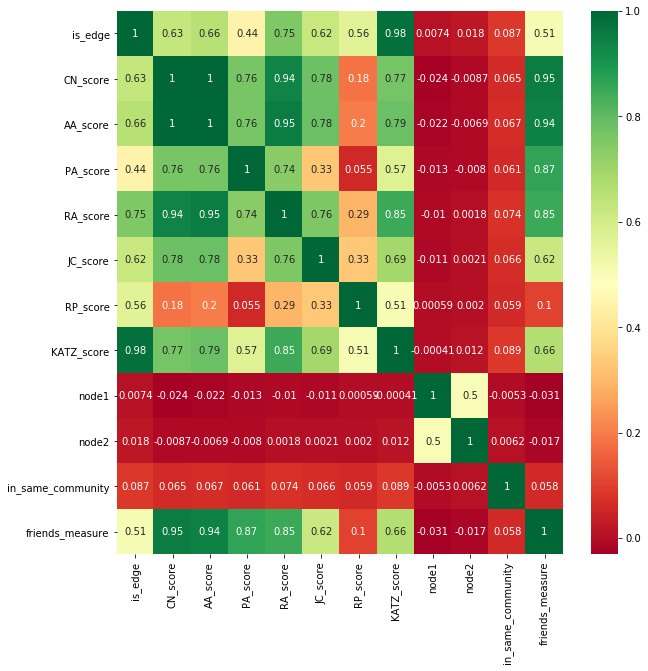

In [0]:
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [0]:
kfold = model_selection.KFold(n_splits=5, random_state=22, shuffle = True)
model_kfold = DecisionTreeClassifier(random_state=0)
results_kfold = model_selection.cross_val_score(model_kfold, X_d, y_d, cv=5, scoring='roc_auc')
print(results_kfold)
print("Accuracy: %.2f%%" % (results_kfold.mean()*100.0)) 

[0.99944737 0.99944737 0.99961741 0.99927733 0.99961741]
Accuracy: 99.95%
